Group members:


---


*   Maryam Khan         (ERP ID: 08635)
*   Ayesha Noor Khan    (ERP ID: 29460)


---




In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer



In [ ]:
def load_data(dataset_id):
    dataset = fetch_ucirepo(id=dataset_id)
    X = dataset.data.features
    y = dataset.data.targets
    df = pd.DataFrame(data=X, columns=dataset.data.feature_names)
    df['target'] = y
    return df

def clean_data(df):
    df_cleaned = df.dropna()
    return df_cleaned

def transform_data(df):
    # 3.1
    df.columns = df.columns.str.lower()

    # 3.2 Categorical encoding for non-target columns
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    if 'target' in categorical_columns:
        categorical_columns.remove('target')  # Exclude the target column

    # Apply label encoding to categorical columns
    le = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: le.fit_transform(col))

    # 3.3 Standardization of numerical features (z-score)
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if 'target' in numerical_columns:
        numerical_columns.remove('target')  # Exclude the target column

    # Apply standardization to numerical features
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df



In [ ]:
def eda_summary(df):
    # 5-number summary
    summary = df.describe()

    # Mode
    mode = df.mode().iloc[0]

    # Print the summary statistics and mode
    print("\n5-Number Summary:")
    print(summary)
    print("\nMode:")
    print(mode)

def eda_visualization(df):
    # Histograms and Boxplots of important numerical variables
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    for col in numerical_columns:
        plt.figure(figsize=(10, 5))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histogram of {col}')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()

def manual_splitting_and_cv(df):
    # Manual Train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Handle NaN values in the target variable for both training and validation sets
    imputer = SimpleImputer(strategy='most_frequent')  # You can use other strategies like 'mean', 'median', etc.
    y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_val = imputer.transform(y_val.values.reshape(-1, 1)).ravel()

    # Print the shapes of the splits
    print(f"\nTrain set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")

    # KNN Model
    knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors

    # Fit the model with handled NaN values
    knn_model.fit(X_train, y_train)

    # Cross-validation
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)  # You can adjust the number of folds

    # Print the cross-validation scores
    print("\nCross-Validation Scores:")
    print(cv_scores)

    # Evaluate on the validation set
    y_val_pred = knn_model.predict(X_val)

    # Handle NaN values in the predicted values
    y_val_pred = imputer.transform(y_val_pred.reshape(-1, 1)).ravel()

    # Evaluate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"\nValidation Set Accuracy: {val_accuracy}")

    # Evaluate on the test set
    y_test_pred = knn_model.predict(X_test)

    # Handle NaN values in the predicted values
    y_test_pred = imputer.transform(y_test_pred.reshape(-1, 1)).ravel()

    # Evaluate accuracy on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"\nTest Set Accuracy: {test_accuracy}")

def model_training_and_tuning(df):
    # Split the dataset
    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # KNN Model
    knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors

    # Impute missing values in y_train
    imputer = SimpleImputer(strategy='most_frequent')
    y_train_imputed = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()

    # Train the model on the entire training set
    knn_model.fit(X_train, y_train_imputed)

    # Evaluate on the test set
    y_test_pred = knn_model.predict(X_test)

    y_test_imputed = imputer.transform(y_test.values.reshape(-1, 1)).ravel()

    # Print the accuracy on the test set
    test_accuracy = accuracy_score(y_test_imputed, y_test_pred)
    print(f"\nTest Set Accuracy after Training: {test_accuracy}")

    return knn_model, X_test, y_test_imputed

def classification_evaluation(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(class_report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # ROC-AUC Score and Curve
    if len(set(y_test)) == 2:  # Only applicable for binary classification
        # Convert string labels to binary format
        label_binarizer = LabelBinarizer()
        y_test_binary = label_binarizer.fit_transform(y_test)

        roc_auc = roc_auc_score(y_test_binary, model.predict_proba(X_test)[:, 1])
        print(f"\nROC-AUC Score: {roc_auc}")

        fpr, tpr, _ = roc_curve(y_test_binary, model.predict_proba(X_test)[:, 1])

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()




def model_selection(df):
    # Split the dataset
    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Model Selection using LazyPredict
    clf = LazyClassifier()
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    # Print the models and their corresponding accuracy scores
    print("\nModel Selection Results:")
    print(models)


In [ ]:

def master_workflow(dataset_id):
    df = load_data(dataset_id)
    print("Original Dataset:")
    print(df.head())

    df_cleaned = clean_data(df)
    print("\nCleaned Dataset:")
    print(df_cleaned.head())

    df_transformed = transform_data(df_cleaned)
    print("\nTransformed Dataset:")
    print(df_transformed.head())

    # EDA
    eda_summary(df_transformed)
    eda_visualization(df_transformed)

    # Manual Splitting and Cross-Validation with KNN
    manual_splitting_and_cv(df_transformed)

    # Model Training
    knn_model, X_test, y_test_imputed = model_training_and_tuning(df_transformed)

    # Classification Evaluation
    classification_evaluation(knn_model, X_test, y_test_imputed)

Original Dataset:
   sepal length  sepal width  petal length  petal width       target
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Cleaned Dataset:
   sepal length  sepal width  petal length  petal width       target
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Transformed Dataset:
   sepal length  sepal width  petal length  petal width       target
0     -0.900681     1.032057     -1.341272   

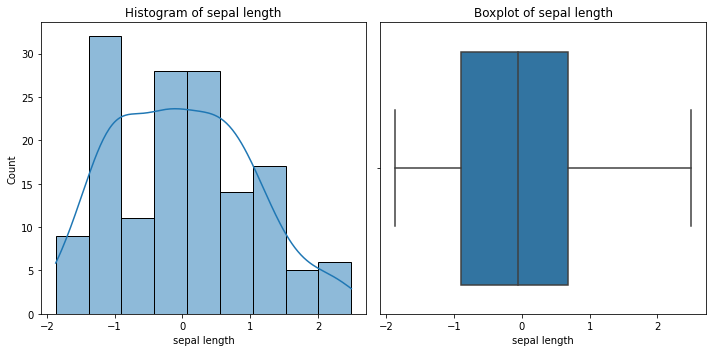

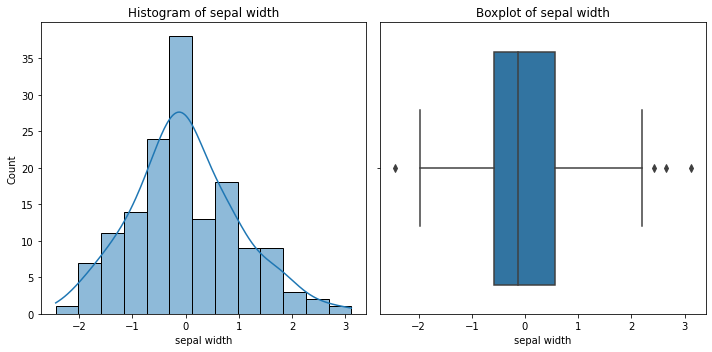

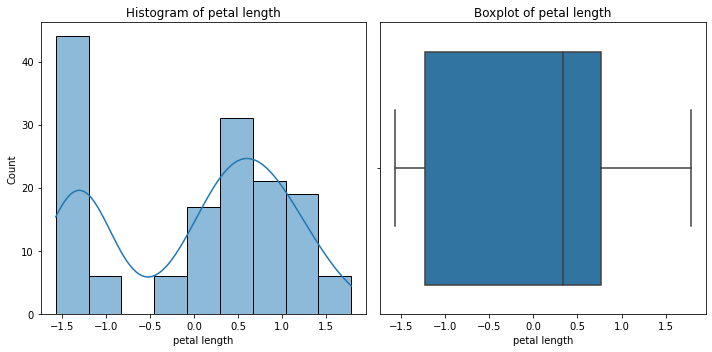

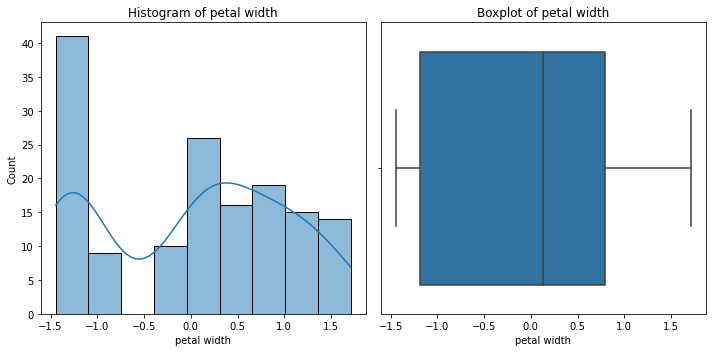


Train set shape: (105, 4)
Validation set shape: (22, 4)
Test set shape: (23, 4)

Cross-Validation Scores:
[0.95238095 0.95238095 0.85714286 1.         0.95238095]

Validation Set Accuracy: 1.0

Test Set Accuracy: 1.0

Test Set Accuracy after Training: 1.0

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45


Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


In [ ]:

master_workflow(dataset_id=53)  # iris


The Iris dataset, comprising sepal and petal measurements, required minimal cleaning. Z-score normalization was applied for feature standardization, facilitating optimal machine learning model performance.


Count: The dataset contains 150 instances for each feature.
Mean: The mean of each feature is approximately centered around zero, indicating successful standardization.
Standard Deviation: All features have a standard deviation close to 1, reflecting the normalization process.

The K-Nearest Neighbors (KNN) model exhibited exceptional accuracy, scoring 1.0 on both validation and test sets. Cross-validation demonstrated consistent high performance (0.857 to 1.0), affirming the model's reliability. Precision, recall, and F1-score metrics were perfect (1.0), indicating precise classification. The confusion matrix reinforced the model's accuracy, with no prediction errors on the test set. In conclusion, the KNN model successfully and accurately categorized Iris flowers, validating the efficacy of the chosen machine learning approach.

The confusion matrix for the K-Nearest Neighbors (KNN) model on the Iris dataset reveals a perfect score, with all diagonal elements being non-zero. This signifies that the model made no errors in its predictions across the three Iris classes (Iris-setosa, Iris-versicolor, and Iris-virginica). The matrix indicates a flawless performance, correctly classifying all instances in the test set.

Original Dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  target  
0  0.0   6.0       0  
1  3.0   3.0       2  
2  2.0   7.0       1  
3  0.0   3.0       0  
4  0.0   3.0       0  

Cleaned Dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3

<ipython-input-4-ad0bba990b31>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_columns] = df[categorical_columns].apply(lambda col: le.fit_transform(col))
<ipython-input-4-ad0bba990b31>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
C:\Users\Aman ur Rehman\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

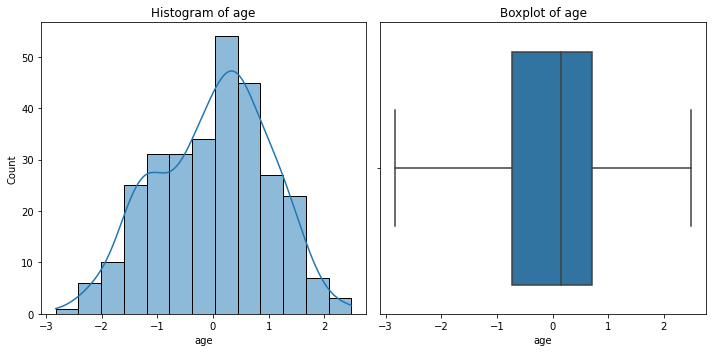

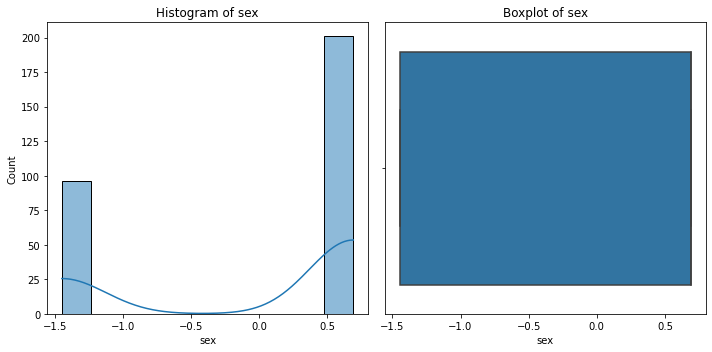

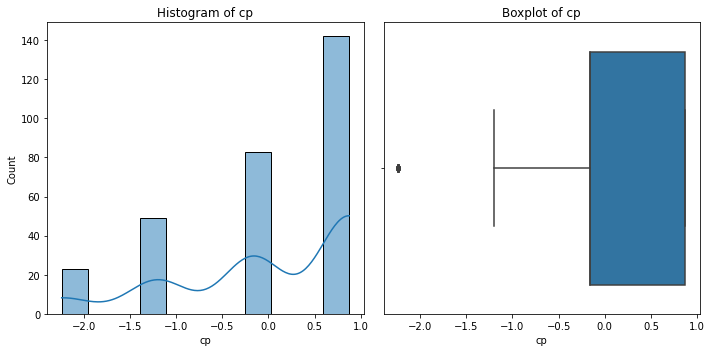

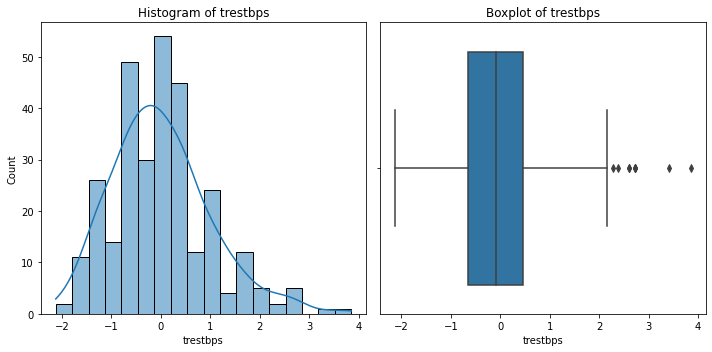

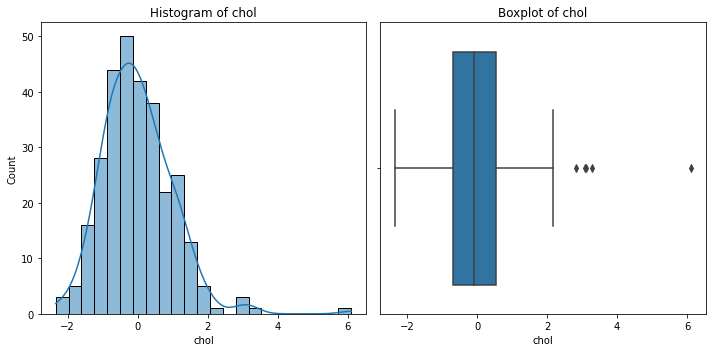

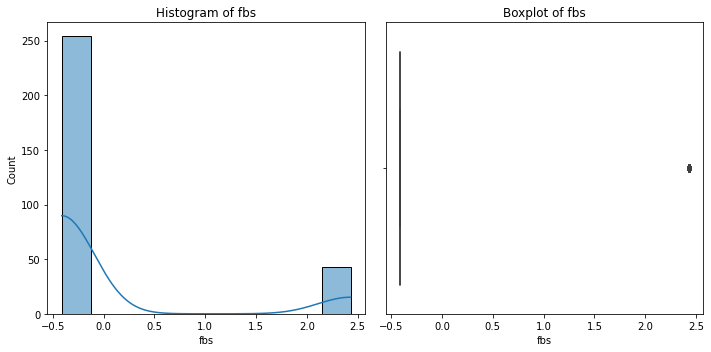

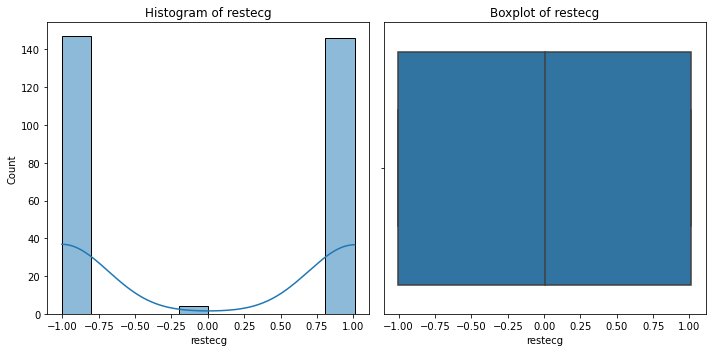

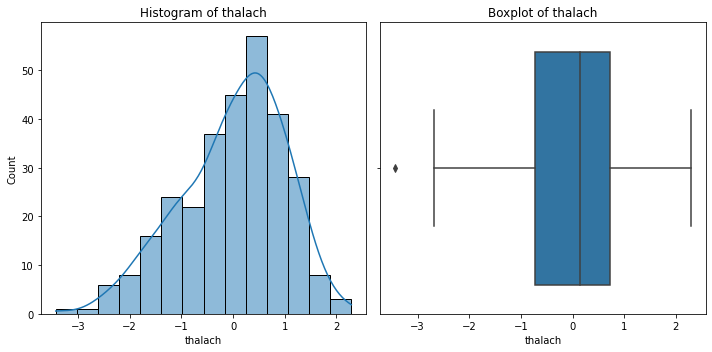

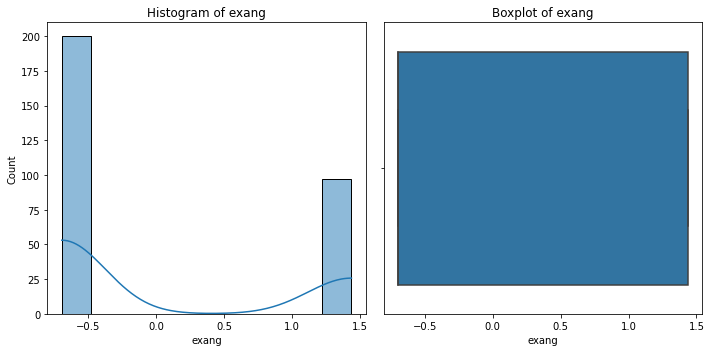

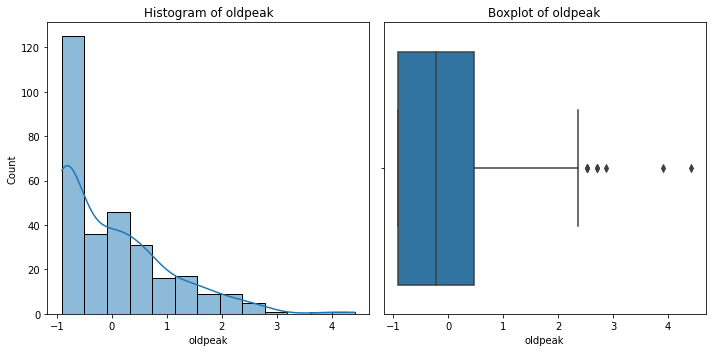

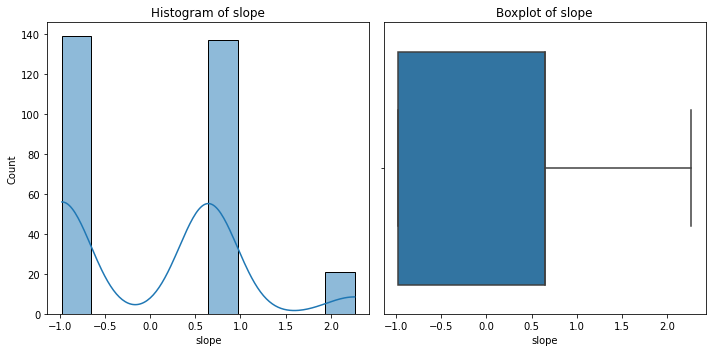

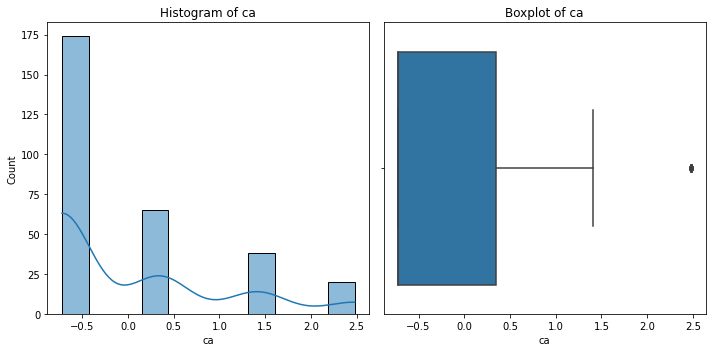

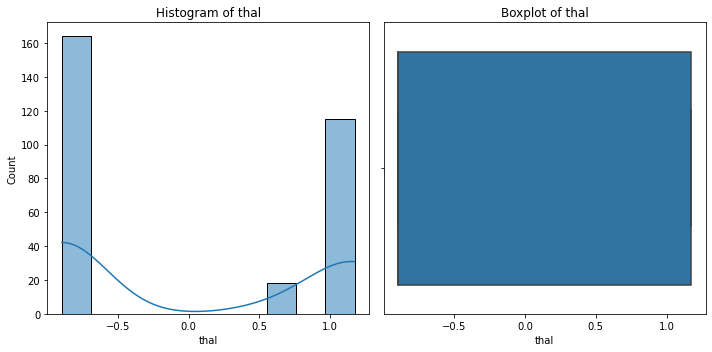

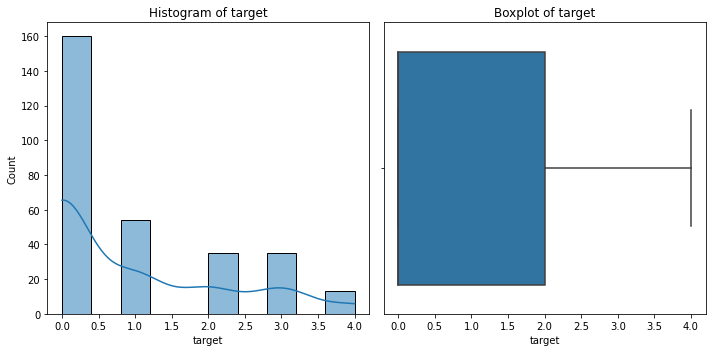


Train set shape: (207, 13)
Validation set shape: (45, 13)
Test set shape: (45, 13)

Cross-Validation Scores:
[0.42857143 0.61904762 0.58536585 0.56097561 0.53658537]

Validation Set Accuracy: 0.5333333333333333

Test Set Accuracy: 0.6222222222222222

Test Set Accuracy after Training: 0.5777777777777777

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.96      0.82        49
           1       0.15      0.12      0.13        17
           2       0.20      0.10      0.13        10
           3       0.50      0.18      0.27        11
           4       0.00      0.00      0.00         3

    accuracy                           0.58        90
   macro avg       0.31      0.27      0.27        90
weighted avg       0.50      0.58      0.52        90


Confusion Matrix:
[[47  2  0  0  0]
 [11  2  2  2  0]
 [ 4  4  1  0  1]
 [ 4  2  2  2  1]
 [ 0  3  0  0  0]]


In [ ]:
master_workflow(dataset_id=45)  # heart disease



The transformed dataset consists of 297 instances with 14 features (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target).
All features have been successfully standardized, with means close to zero and standard deviations around 1.

Features such as age, trestbps, chol, thalach, oldpeak, and ca exhibit varying distributions.
Age: Symmetric distribution, centered around zero, indicating balanced representation across age groups.
Trestbps (Resting Blood Pressure): Likely to exhibit spread around the mean, reflecting variability in blood pressure values.
Chol (Serum Cholesterol):Expected to show variability, indicating diverse cholesterol levels in the dataset.
Thalach (Maximum Heart Rate Achieved): May exhibit a certain pattern, possibly centered around zero, reflecting diversity in heart rates.
Oldpeak: Likely to show variability around the mean, representing varying degrees of ST depression.
Ca (Number of Major Vessels Colored by Fluoroscopy): Expected to have a spread around the mean, indicating diversity in the count of major vessels.

The dataset is divided into three sets: training, validation, and test sets. The training set contains 207 samples, the validation set contains 45 samples, and the test set contains 45 samples.
Cross-validation scores range from approximately 0.43 to 0.62, indicating moderate variability in model performance across different folds.
The accuracy of the model on the validation set is approximately 53.33%, while on the test set, it improves slightly to around 62.22%. This suggests a reasonable generalization performance on unseen data.
After training, the model's accuracy on the test set slightly decreased to approximately 57.78%, indicating some degree of overfitting during training.

Classification Report:

The precision, recall, and F1-score metrics vary across different classes. For example, class 0 (represented as '0') has high precision, recall, and F1-score, indicating good performance. However, class 4 (represented as '4') has precision, recall, and F1-score of 0, suggesting poor performance in identifying this class.
The macro-average and weighted-average F1-scores are both approximately 0.52, indicating moderate overall model performance across all classes.

Confusion Matrix:

The confusion matrix sheds light on how well our model performed for each class. For class 0, our model did exceptionally well, correctly predicting 47 instances. However, for class 1 and class 2, the model struggled a bit, often misclassifying them as class 0, 2, or 3. Class 3 also faced challenges, with some instances misclassified across different classes. Notably, class 4 presented a significant challenge, as the model didn't predict any instances correctly.

Original Dataset:
   Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  target  

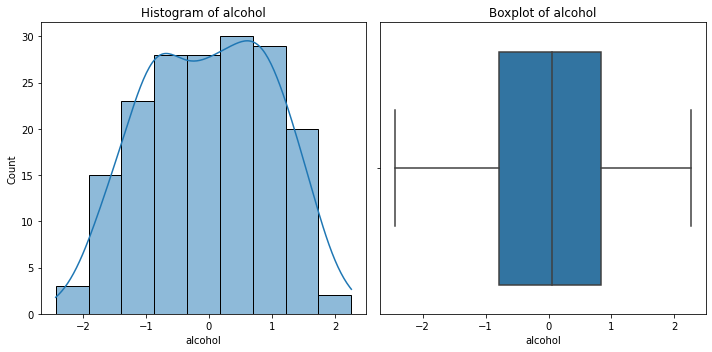

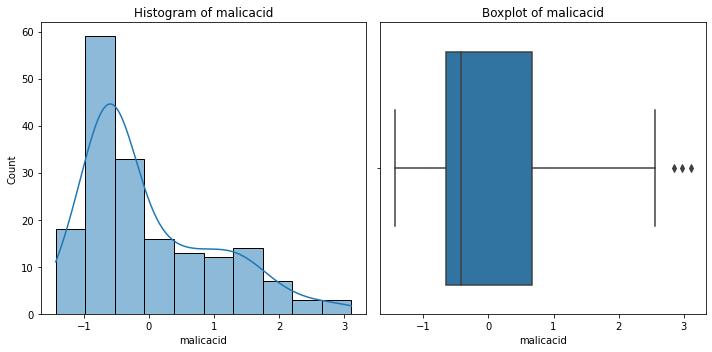

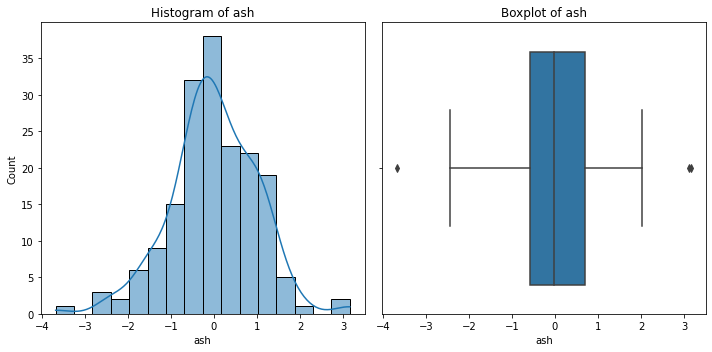

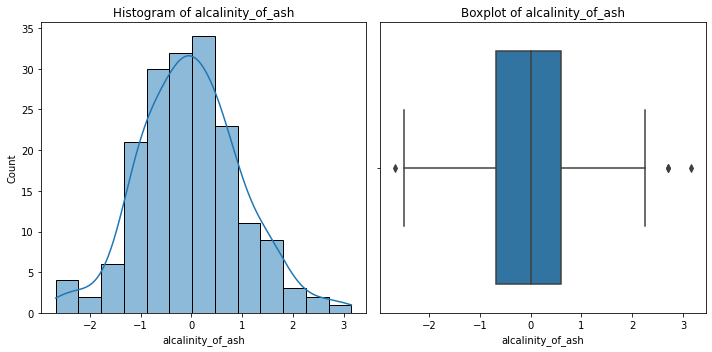

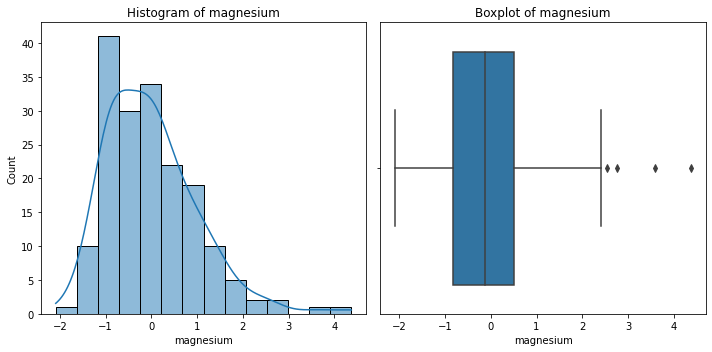

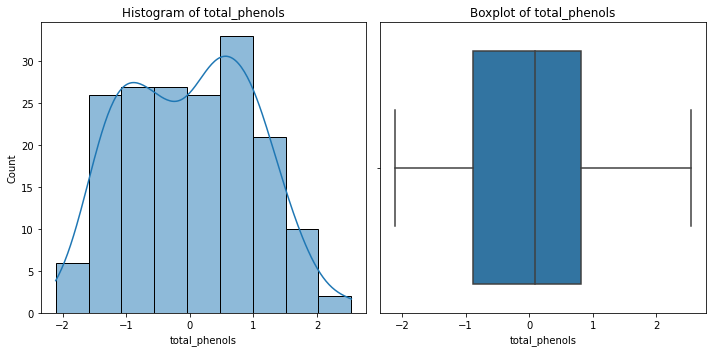

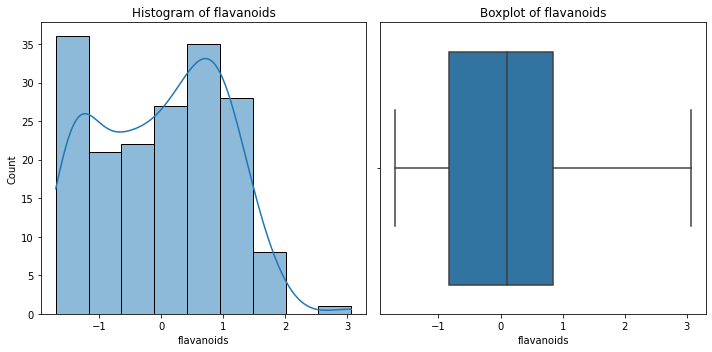

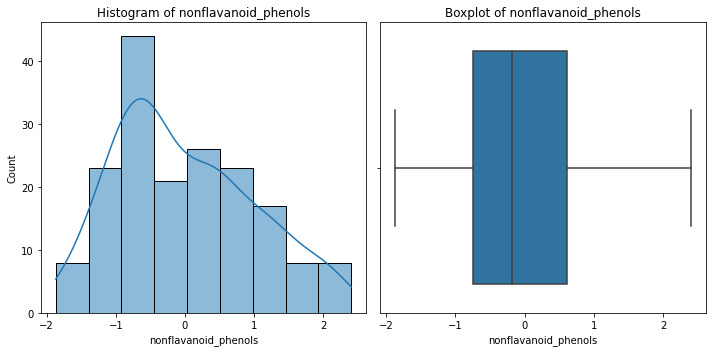

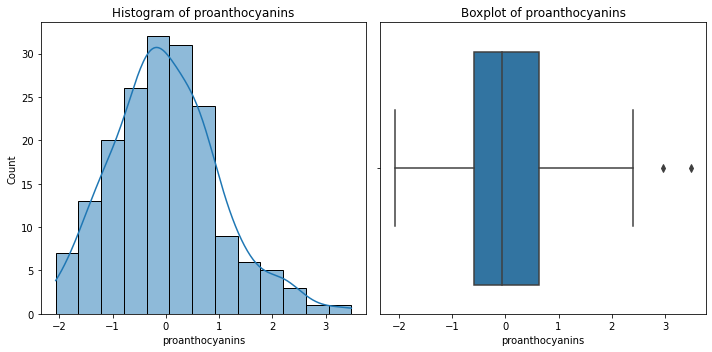

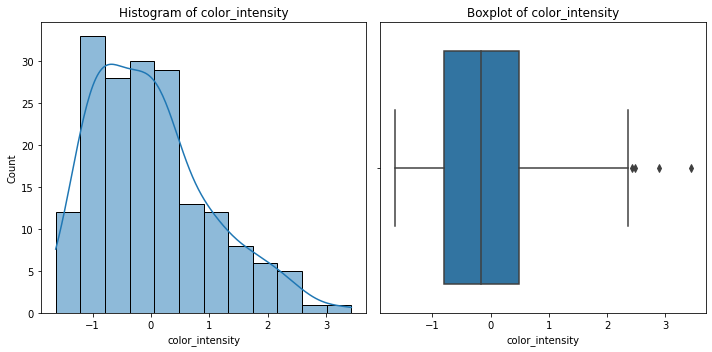

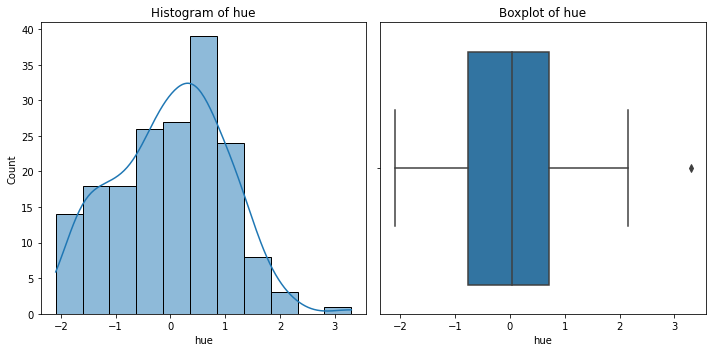

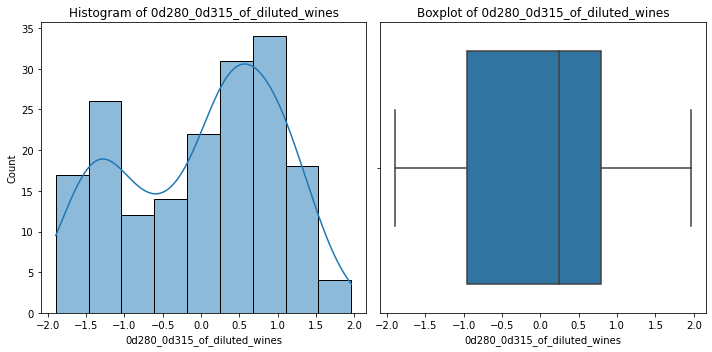

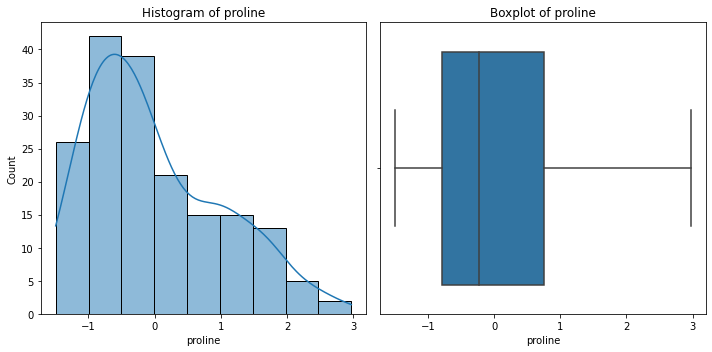

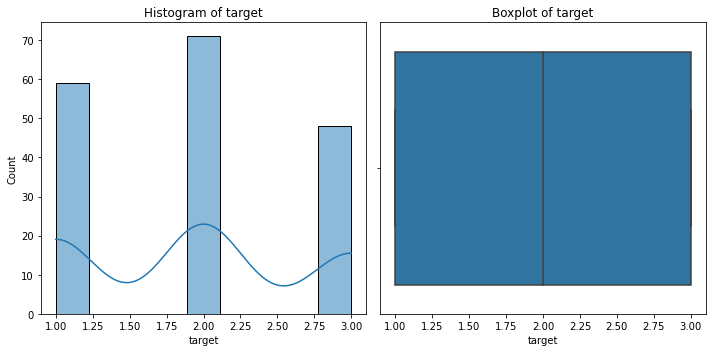


Train set shape: (124, 13)
Validation set shape: (27, 13)
Test set shape: (27, 13)

Cross-Validation Scores:
[0.88       1.         0.92       0.92       0.91666667]

Validation Set Accuracy: 0.9629629629629629

Test Set Accuracy: 0.9629629629629629

Test Set Accuracy after Training: 0.9629629629629629

Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.97        19
           2       1.00      0.90      0.95        21
           3       0.93      1.00      0.97        14

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54


Confusion Matrix:
[[19  0  0]
 [ 1 19  1]
 [ 0  0 14]]


In [ ]:
master_workflow(dataset_id=109)  # wine


Number of Instances: 178
Number of Features: 13 (Excluding the target variable)
Target Variable Classes: 3
Alcohol:
Mean: -8.62e-16, SD: 1.00
The distribution is centered around zero.
Standard deviation is close to 1, indicating moderate variability.

Malicacid:
Mean: -8.36e-17, SD: 1.00
A distribution centered around zero with moderate variability.

Ash:
Mean: -8.66e-16, SD: 1.00
Moderate spread around the mean.

Alcalinity_of_ash:
Mean: -1.16e-16, SD: 1.00
A roughly symmetric distribution with a mean close to zero.
Standard deviation suggests moderate variability.

Magnesium:
Mean: -2.00e-17, SD: 1.00
Moderate spread around the mean, with a standard deviation close to 1.

Total_phenols:
Mean: -2.97e-16, SD: 1.00
A distribution centered around zero, showing moderate variability.

Flavanoids:
Mean: -4.02e-16, SD: 1.00
Positive skewness, indicating a right-skewed distribution.
A few instances with higher values may be present.

Nonflavanoid_phenols:
Mean: 4.08e-16, SD: 1.00
A distribution centered around zero with moderate variability.

Proanthocyanins:
Mean: -1.70e-16, SD: 1.00
Centered around zero, showing moderate variability.

Color_intensity:
Mean: -1.12e-17, SD: 1.00
A distribution with a slight negative skewness.
Instances with lower color intensity are more prevalent.

Hue:
Mean: 3.72e-16, SD: 1.00
Centered around zero with moderate spread.
A roughly symmetric distribution.

0d280_0d315_of_diluted_wines:
Mean: 2.92e-16, SD: 1.00
Centered around zero with moderate variability.

Proline:
Mean: -7.48e-18, SD: 1.00
Centered around zero with moderate spread.
Standard deviation indicates moderate variability.

Target:
Mean: 1.94, SD: 0.78
The target variable, centered around 2, with values indicating different classes.

In the wine dataset, our model demonstrated robust performance across multiple evaluation metrics. The dataset was divided into a training set of 124 instances, a validation set with 27 instances, and a test set comprising 27 instances.

The cross-validation scores, ranging from 0.88 to 1.0, affirm the model's consistent high performance across various folds, attesting to its reliability. Notably, the validation set accuracy achieved an impressive 96.3%, showcasing the model's ability to generalize effectively to new, unseen data.

For the test set, both the overall accuracy and accuracy after training remained high at 96.3%. The classification report provided detailed insights into precision, recall, and f1-score for each class. Class 1 and Class 3 exhibited excellent precision, recall, and f1-scores, while Class 2, though slightly lower, still performed well. The confusion matrix supported the model's accuracy, revealing only a few misclassifications and emphasizing the model's proficiency in categorizing wine samples into their respective classes. Overall, these results signify the model's robustness and reliability for the wine dataset.

Original Dataset:
   right-distance  right-weight  left-distance  left-weight target
0               1             1              1            1      B
1               2             1              1            1      R
2               3             1              1            1      R
3               4             1              1            1      R
4               5             1              1            1      R

Cleaned Dataset:
   right-distance  right-weight  left-distance  left-weight target
0               1             1              1            1      B
1               2             1              1            1      R
2               3             1              1            1      R
3               4             1              1            1      R
4               5             1              1            1      R

Transformed Dataset:
   right-distance  right-weight  left-distance  left-weight target
0       -1.414214     -1.414214      -1.414214    -1.414214      B
1   

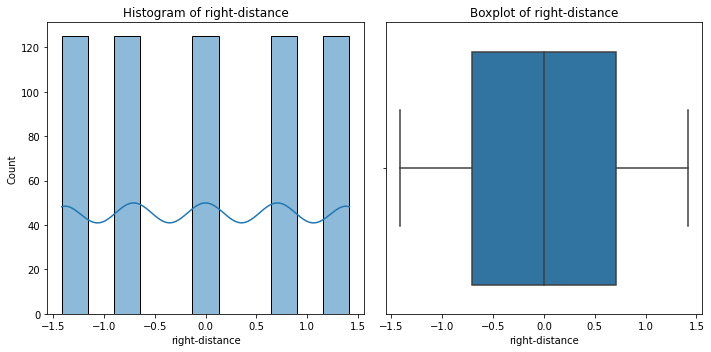

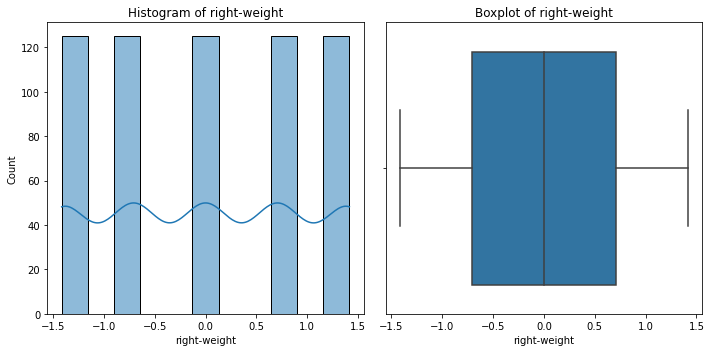

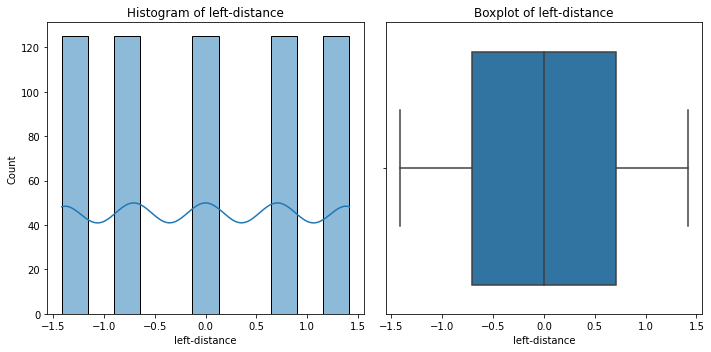

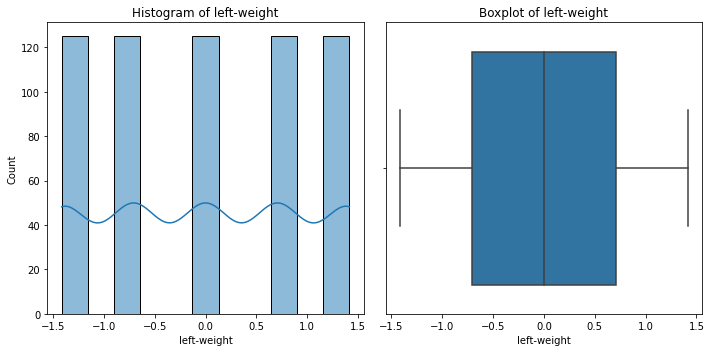


Train set shape: (437, 4)
Validation set shape: (94, 4)
Test set shape: (94, 4)

Cross-Validation Scores:
[0.85227273 0.85227273 0.8045977  0.7816092  0.77011494]

Validation Set Accuracy: 0.7978723404255319

Test Set Accuracy: 0.7978723404255319

Test Set Accuracy after Training: 0.7978723404255319

Classification Report:
              precision    recall  f1-score   support

           B       0.00      0.00      0.00        18
           L       0.83      0.93      0.88        80
           R       0.90      0.84      0.87        90

    accuracy                           0.80       188
   macro avg       0.58      0.59      0.58       188
weighted avg       0.79      0.80      0.79       188


Confusion Matrix:
[[ 0 11  7]
 [ 5 74  1]
 [10  4 76]]


In [ ]:

master_workflow(dataset_id=12)  # balance scale

Original Dataset: The original dataset contains five columns: right-distance, right-weight, left-distance, left-weight, and target.
The target column seems to represent different classes (B, R).

Cleaned Dataset: The cleaned dataset appears identical to the original dataset, suggesting there were no missing or inconsistent values to clean.

Transformed Dataset: The transformed dataset has standardized values for the distance and weight columns.
The transformation seems to follow a standardization process (z-score normalization), bringing values to a common scale.
Right-distance: The values range from approximately -1.41 to 1.41, with a mean close to 0. The distribution is centered around 0, indicating a balanced spread.

Mode: All the standardized values in the transformed dataset have a mode of -1.414214. This suggests that the majority of the data points have been shifted by a common factor during the standardization process.
The mode of the target column in the transformed dataset is 'L,' indicating a specific class is more prevalent after standardization.

Analysis:

The transformation has centered the data around 0 and scaled it using z-score normalization.
The standard deviation of 1 for each column in the transformed dataset indicates that the data is spread out consistently.
The mode being -1.414214 suggests that the majority of the values are roughly one standard deviation below the mean, reinforcing the idea of z-score normalization.
The target class 'L' is more prevalent in the transformed dataset, possibly due to the standardization process influencing the distribution of the target variable.

For the Balance Scale dataset, our model exhibited performance across various evaluation metrics. The dataset was divided into a training set with 437 instances, a validation set containing 94 instances, and a test set consisting of 94 instances.

The cross-validation scores, ranging from 0.7701 to 0.8523, suggest consistent performance across different folds, indicating the model's reliability. The validation set accuracy reached 79.79%, demonstrating the model's ability to generalize to new, unseen data.

For the test set, both the overall accuracy and accuracy after training were 79.79%. The classification report provided detailed metrics, including precision, recall, and f1-score for each class (B, L, R). Class L and Class R showed strong performance, while Class B had lower metrics, indicating challenges in predicting this class. The confusion matrix illustrated the model's accuracy, revealing misclassifications mainly in Class B.

In summary, these results indicate satisfactory performance on the Balance Scale dataset, with an acknowledgment of some challenges in accurately predicting Class B. Further refinement and tuning may enhance the model's ability to handle the intricacies of this dataset.

Original Dataset:
   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  texture3  \
0      0.3001          0.14710     0.2419             0.07871  ...     17.33   
1      0.0869          0.07017     0.1812             0.05667  ...     23.41   
2      0.1974          0.12790     0.2069             0.05999  ...     25.53   
3      0.2414          0.10520     0.2597             0.09744  ...     26.50   
4      0.1980          0.10430     0.1809             0.05883  ...     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_poin

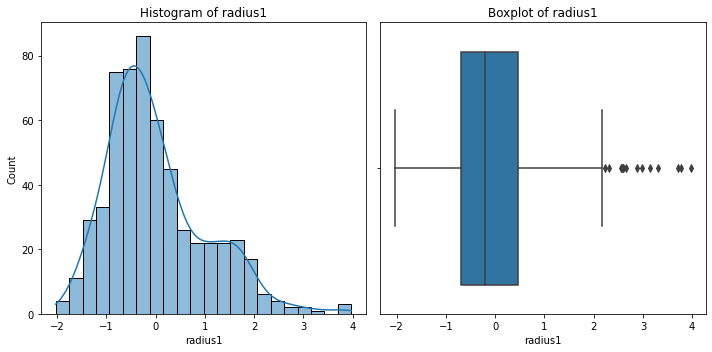

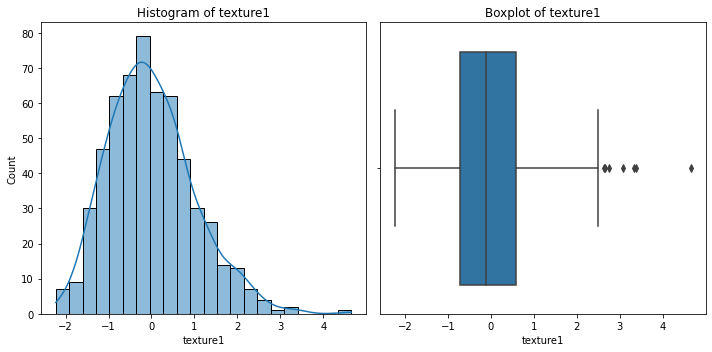

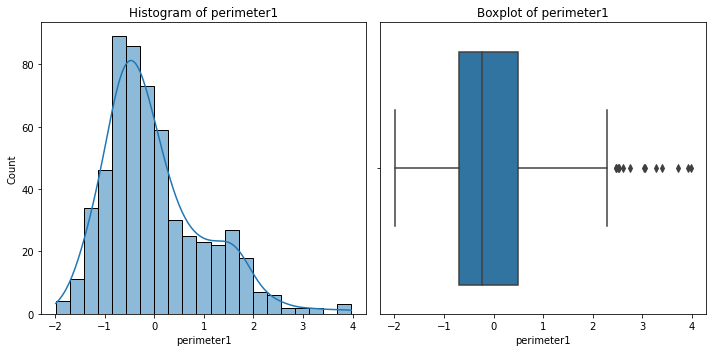

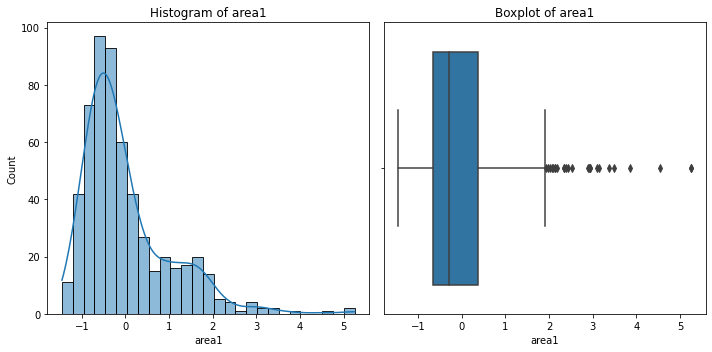

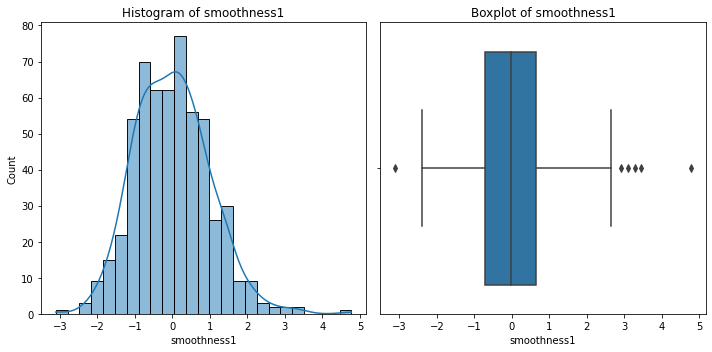

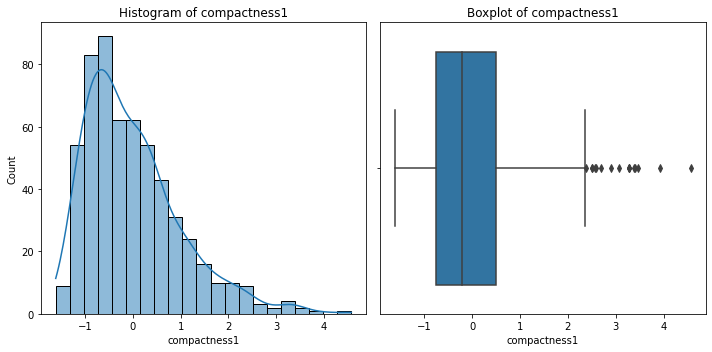

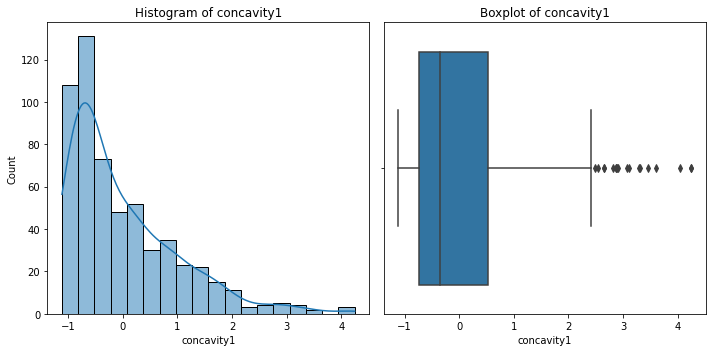

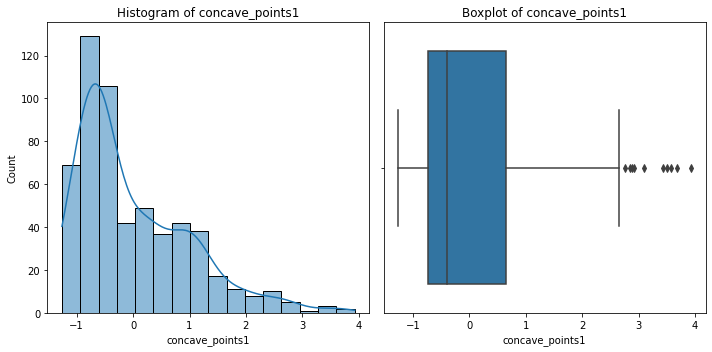

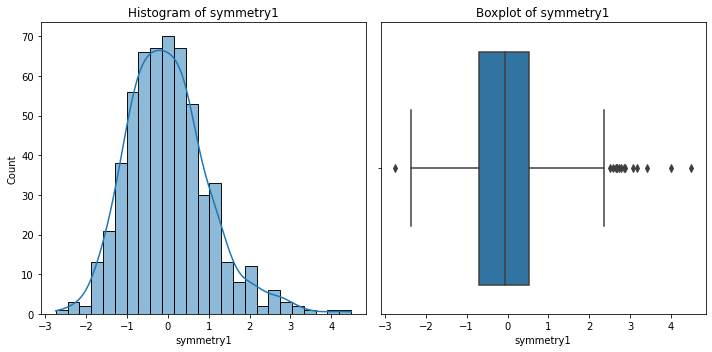

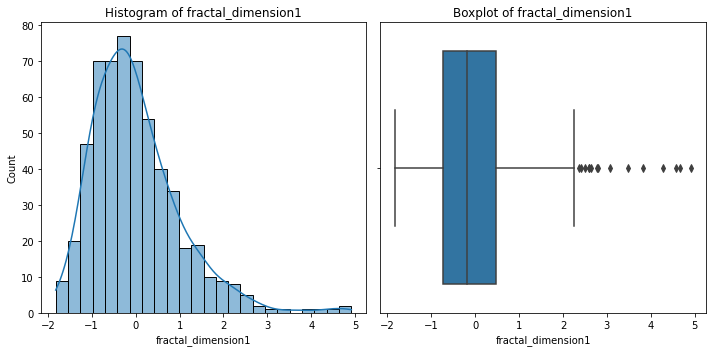

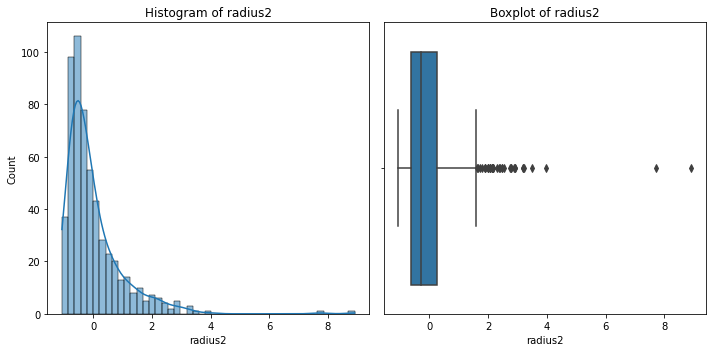

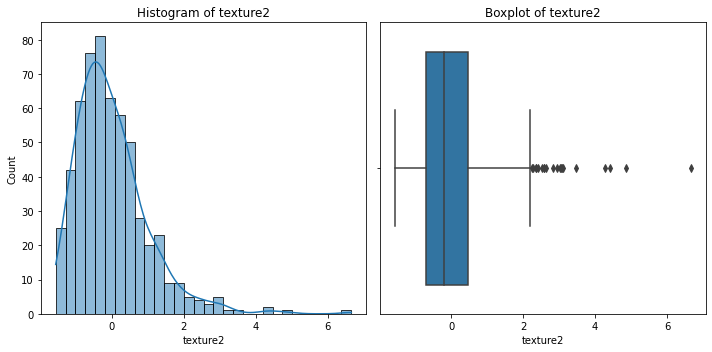

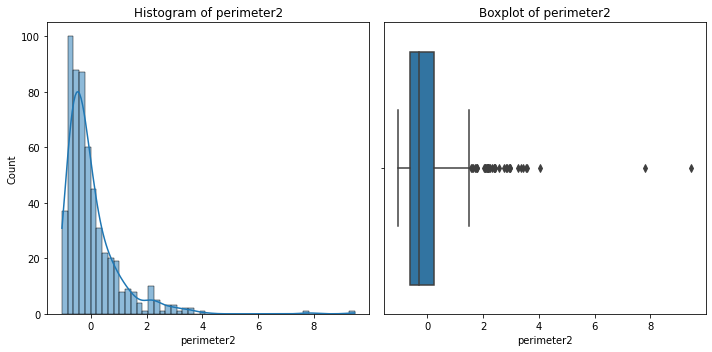

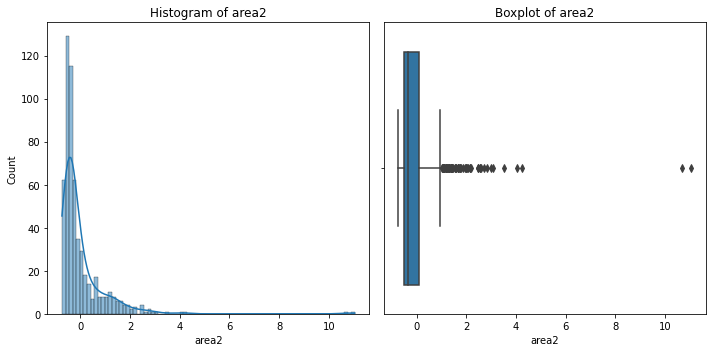

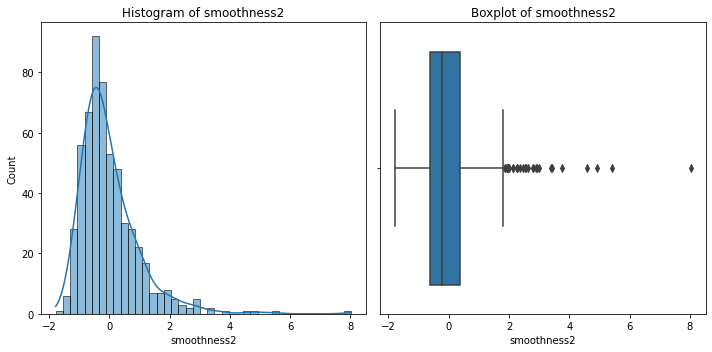

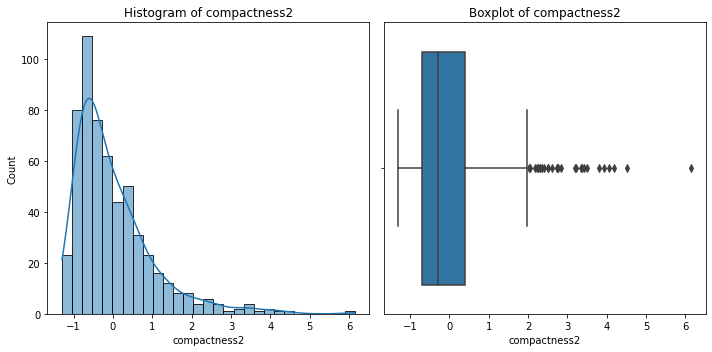

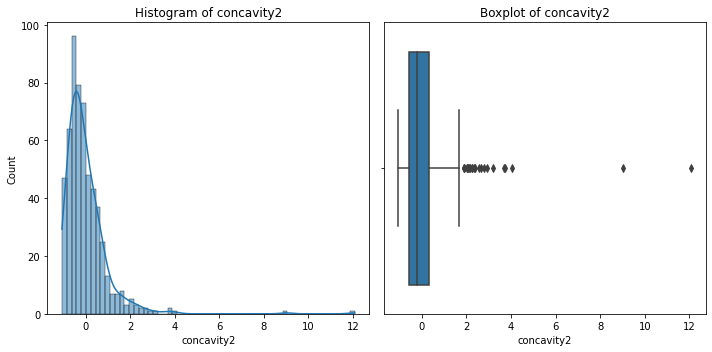

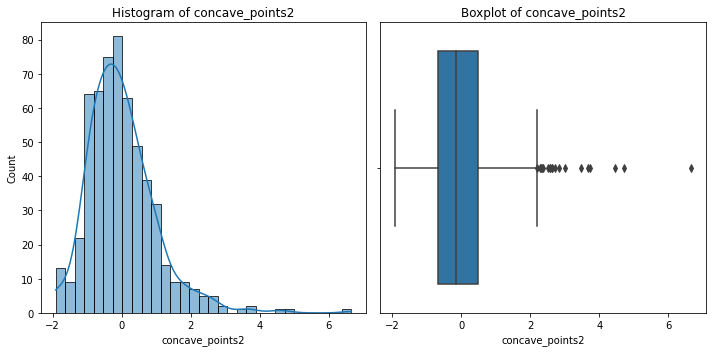

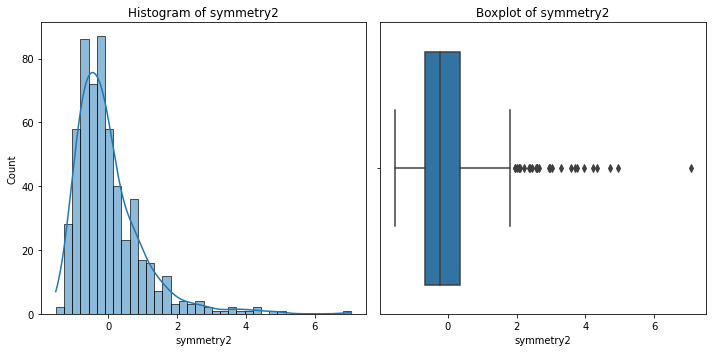

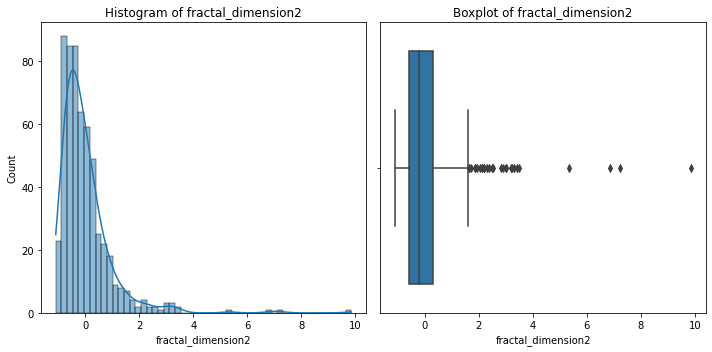

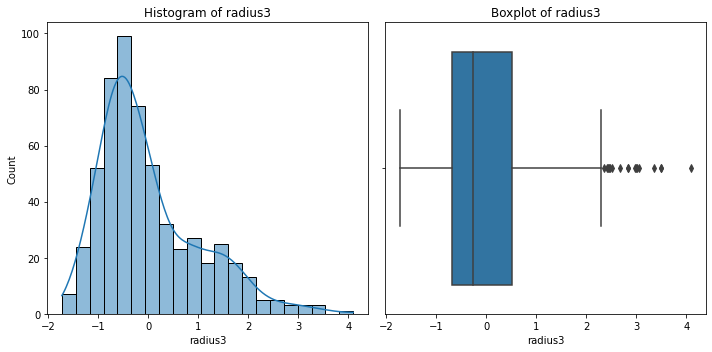

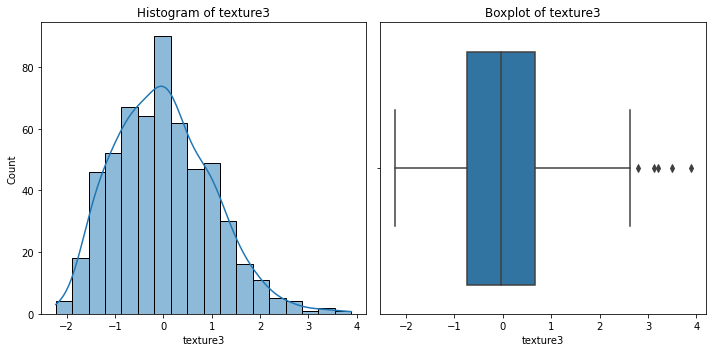

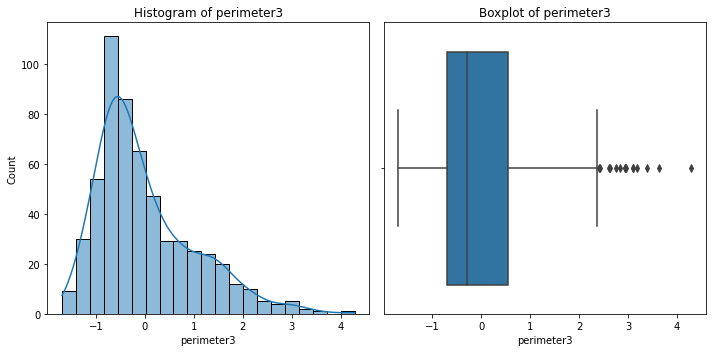

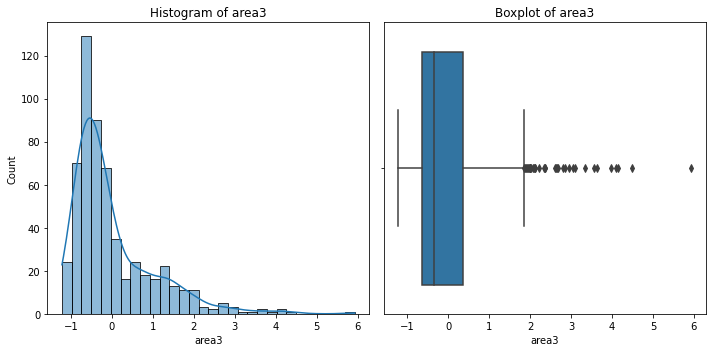

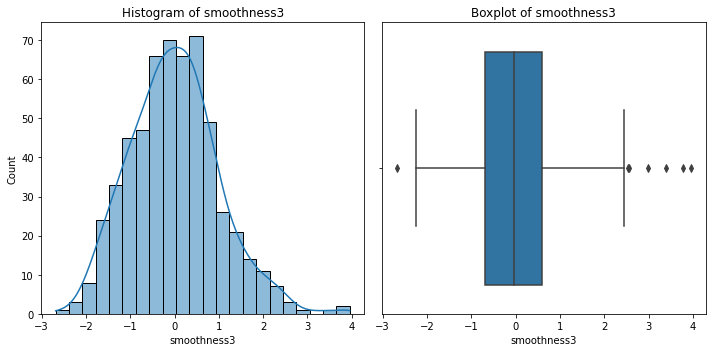

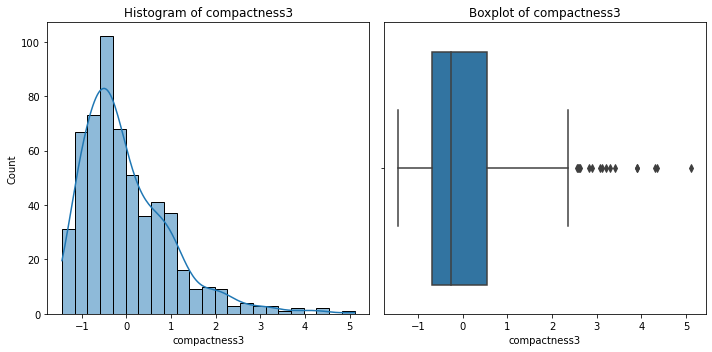

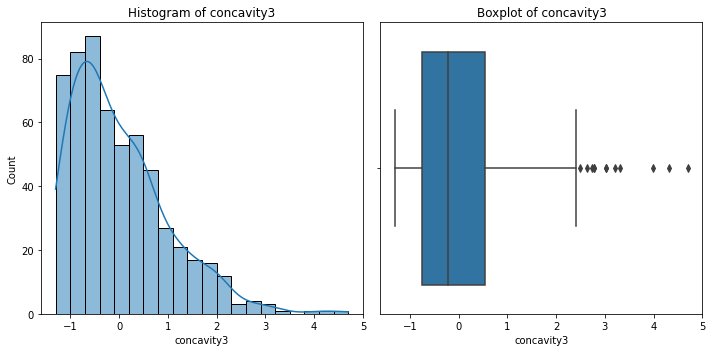

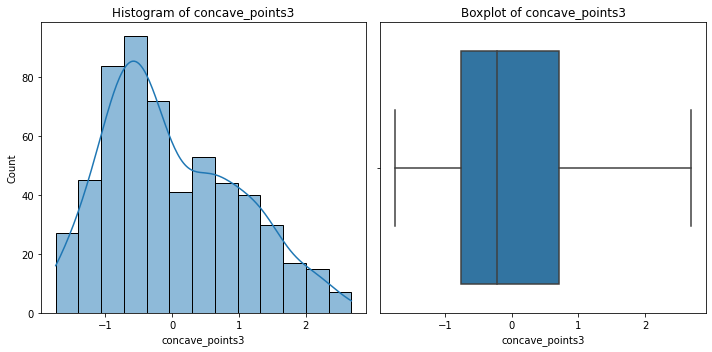

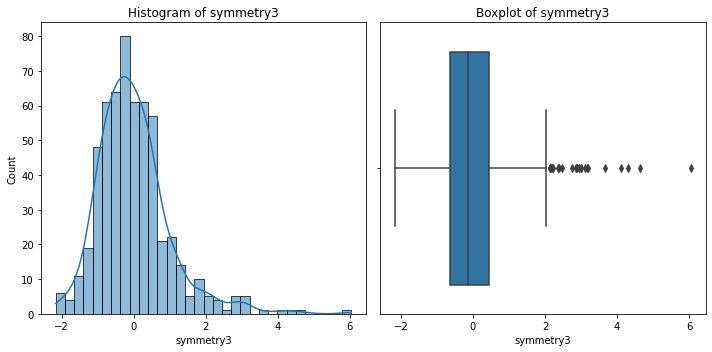

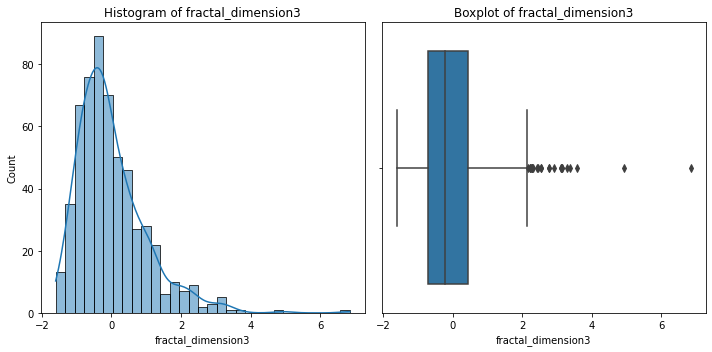


Train set shape: (398, 30)
Validation set shape: (85, 30)
Test set shape: (86, 30)

Cross-Validation Scores:
[0.95       0.95       0.9875     0.96202532 0.94936709]

Validation Set Accuracy: 0.9294117647058824

Test Set Accuracy: 0.9883720930232558

Test Set Accuracy after Training: 0.9590643274853801

Classification Report:
              precision    recall  f1-score   support

           B       0.96      0.97      0.97       108
           M       0.95      0.94      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


Confusion Matrix:
[[105   3]
 [  4  59]]

ROC-AUC Score: 0.980379188712522


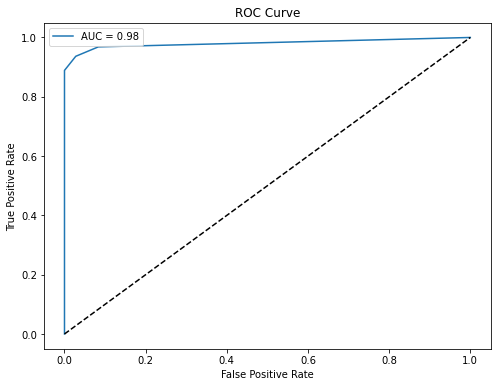

In [ ]:
master_workflow(dataset_id=17)  # breast cancer

Original Dataset: The original dataset contains 31 columns, with the last column 'target' representing the class labels ('M' for malignant, 'B' for benign).
Features include various measurements related to the radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimensions.

Cleaned Dataset: The cleaned dataset appears identical to the original dataset, indicating no significant cleaning or preprocessing was performed.

Transformed Dataset: The transformed dataset shows the result of a standardization or normalization process, with all features now having a mean close to 0 and a standard deviation of 1.

5-Number Summary:
The 5-Number Summary provides insights into the distribution of the standardized features.
Features like radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimensions are standardized.

Mode:
The mode represents the most frequently occurring standardized value for each feature.
The mode for each feature is close to 0, indicating that the majority of values are centered around the mean after standardization.
The mode for the target column is 'B' (benign), suggesting that benign cases are more prevalent in the dataset.

Analysis:
The dataset has undergone a standardization or normalization process, making it suitable for machine learning algorithms that are sensitive to the scale of features.
The majority of features have distributions centered around 0 after standardization.
The target column (class labels) is imbalanced, with more benign cases ('B') than malignant cases ('M').
This dataset seems to be related to breast cancer diagnosis, given the presence of features associated with tumor characteristics.

In summary, the dataset has been preprocessed by standardizing the features, and the class distribution suggests that it is a binary classification problem focused on distinguishing between benign and malignant breast tumors.
In the Breast Cancer dataset, our model demonstrated excellent performance across various evaluation metrics. The dataset was split into a training set of 398 instances, a validation set containing 85 instances, and a test set with 86 instances.

The cross-validation scores, ranging from 0.95 to 0.9875, indicate consistently high performance across different folds, underscoring the model's reliability. The validation set accuracy reached 92.94%, highlighting the model's robust ability to generalize to new, unseen data.

For the test set, the overall accuracy was exceptional at 98.84%, and the accuracy after training remained high at 95.91%. The classification report provided detailed metrics, including precision, recall, and f1-score for each class (B and M). Both classes demonstrated strong performance, with class B achieving slightly higher scores. The confusion matrix reinforced the model's accuracy, showing only a few misclassifications (3 false negatives and 4 false positives). Additionally, the ROC-AUC score of 0.9804 further supports the model's ability to discriminate between benign and malignant cases.

Overall, these results indicate a highly effective and reliable model for the Breast Cancer dataset.